In [1]:
from __future__ import print_function 

import numpy as np
import pandas as pd
import matplotlib as mpl
import os.path #for saving
import ipywidgets as widgets
import math
import sys
import cv2

from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.patches import Rectangle #for pixel plot
from mpl_toolkits.mplot3d import axes3d  #for pyramid
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection 
from IPython.display import display #for widgets
from skimage import data #for transformation
from skimage import transform as tf
from itertools import compress #for subsetting lists with index

%matplotlib nbagg
# Magic for plots in aseparate window. Alternatives: 'notebook' and 'inline' (HTML)

print(sys.prefix)
print(cv2.__version__) #open cv version

C:\Users\Acer\Anaconda3
3.4.1


In [2]:
# Dropdown menus
technique = ["Optical", "SEM", "Laser"]

#optical
modalities_OM = ["reflected", "transmitted"]
angles_OM = np.arange(0, 181, 15)

#SEM
modalities_SEM = ["EDX", "BSE", "SE"]
map_EDX = ["QuantMap", "TruMap", "PhaseMap"]
nElements = 28

#Laser
modes_Laser = ["TOF", "Quadrupole"]

#Properties
binningFactor = [1, 2, 4, 8, 16, 32, 64]
bitDepth = [8, 16, 24, 32, 64]
nIsotopes = 0 #not used

# Initial input
sample = "MBS-4"

# Saving directory
directory = './results/'
if not os.path.isdir(directory):
    os.mkdir(directory)

In [3]:
# Images metadata

#Option 1: Manual user input into notebook (default)
#Option 2: Manual user input to GUI interface..
#Option 3: Information should be loaded automatically from diverse metadata files (OME-TIFF.xml)

#Color legend
layerColors = ['yellow', 'red', 'blue', 'cyan', 'grey', 'magenta']

experiments = []
#OM RL PPL
exp_type = technique[0]+ " " +modalities_OM[0]+ " " + str(angles_OM[0])
exp_bitDepth = bitDepth[0]
exp_binningFactor = binningFactor[0]
exp_channels = 3*len(angles_OM[0:1])
exp_spatialResolution = 0.58
exp_width = 73271
exp_height = 44296
exp_tileWidth = 4908
exp_tileHeight = 3264
exp_overlap = 15
layer = [exp_type, exp_bitDepth, exp_channels, exp_spatialResolution,
         exp_binningFactor, exp_width, exp_height, exp_tileWidth, 
         exp_tileHeight, exp_overlap]
experiments.append(layer)

#BSE
exp_type = technique[1]+ " " +modalities_SEM[1]
exp_bitDepth = bitDepth[0]
exp_binningFactor = binningFactor[0]
exp_channels = 1
exp_spatialResolution = 2.6
exp_width = 15943
exp_height = 9265
exp_tileWidth = 768
exp_tileHeight = 768
exp_overlap = 15
layer = [exp_type, exp_bitDepth, exp_channels, exp_spatialResolution,
         exp_binningFactor, exp_width, exp_height, exp_tileWidth, 
         exp_tileHeight, exp_overlap]
experiments.append(layer)

#TruMap
exp_type = technique[1]+ " " +modalities_SEM[0]+ " " +map_EDX[1]
exp_bitDepth = bitDepth[1]
exp_binningFactor = binningFactor[0]
exp_channels = nElements
exp_spatialResolution = 3.91
exp_width = 9267
exp_height = 5913
exp_tileWidth = 512
exp_tileHeight = 384
exp_overlap = 15
layer = [exp_type, exp_bitDepth, exp_channels, exp_spatialResolution,
         exp_binningFactor, exp_width, exp_height, exp_tileWidth, 
         exp_tileHeight, exp_overlap]
experiments.append(layer)

#PhaseMap
exp_type = technique[1]+ " " +modalities_SEM[0]+ " " +map_EDX[2]
exp_bitDepth = bitDepth[0]
exp_binningFactor = binningFactor[0]
exp_channels = 1
exp_angles = angles_OM[0]
exp_spatialResolution = 3.91
exp_width = 9267
exp_height = 5913
exp_tileWidth = 512
exp_tileHeight = 384
exp_overlap = 15
layer = [exp_type, exp_bitDepth, exp_channels, exp_spatialResolution,
         exp_binningFactor, exp_width, exp_height, exp_tileWidth, 
         exp_tileHeight, exp_overlap]
experiments.append(layer)

#QuantMap
exp_type = technique[1]+ " " +modalities_SEM[0]+ " " +map_EDX[0]
exp_bitDepth = bitDepth[3]
exp_binningFactor = binningFactor[1]
exp_channels = nElements
exp_spatialResolution = 3.91
exp_width = 4633
exp_height = 2956
exp_tileWidth = 256
exp_tileHeight = 192
exp_overlap = 15
layer = [exp_type, exp_bitDepth, exp_channels, exp_spatialResolution,
         exp_binningFactor, exp_width, exp_height, exp_tileWidth, 
         exp_tileHeight, exp_overlap]
experiments.append(layer)

#LA-ICP-Q-MS mapping
exp_type = technique[2]+ " " +modes_Laser[1]
exp_bitDepth = bitDepth[3]
exp_binningFactor = binningFactor[0]
exp_channels = nIsotopes
exp_spatialResolution = 9
exp_width = 100
exp_height = 100
exp_tileWidth = np.nan
exp_tileHeight = np.nan
exp_overlap = np.nan
layer = [exp_type, exp_bitDepth, exp_channels, exp_spatialResolution,
         exp_binningFactor, exp_width, exp_height, exp_tileWidth, 
         exp_tileHeight, exp_overlap]
experiments.append(layer)

dfPyramid = pd.DataFrame(experiments, 
                         columns=['Layer', 'Bit depth', 'Num. channels', 'Spatial resolution', 
                                  'Binning factor', 'Width', 'Height', 
                                  'Tile width', 'Tile height', 'Overlap'])

#Estimating Minimum number of tiles: rows = 1 + 100*(h/d -1)/(100-overlap); 
dfPyramid['Rows'] = 1 + np.round( 100* (dfPyramid['Height']/dfPyramid['Tile height'] - 1)
                            /(100-dfPyramid['Overlap']) )
dfPyramid['Columns'] = 1 + np.round( 100* (dfPyramid['Width']/dfPyramid['Tile width'] - 1)
                               /(100-dfPyramid['Overlap']) )
# Maximum = Minimum + 1 (depends of software clamping of section)

#Custom extra columns
dfPyramid['binnedResolution'] = dfPyramid['Spatial resolution']*dfPyramid['Binning factor']
dfPyramid['userColors'] = layerColors
dfPyramid['tileWidthSize'] = dfPyramid['Tile width']*dfPyramid['binnedResolution']
dfPyramid['tileHeightSize'] = dfPyramid['Tile height']*dfPyramid['binnedResolution']
dfPyramid['tileArea'] = dfPyramid['tileWidthSize']*dfPyramid['tileHeightSize'] #pixels square

# Saving input to csv
filename = sample + '_userInput' + '.csv'
file_path = os.path.join(directory, filename)
dfPyramid.to_csv (file_path, index = False, header=True)

In [4]:
# Loading previous dataframe input
filename = sample + '_userInput' + '.csv'
file_path = os.path.join(directory, filename)
dfPyramid = pd.read_csv(file_path) 

dfPyramid

,Layer,Bit depth,Num. channels,Spatial resolution,Binning factor,Width,Height,Tile width,Tile height,Overlap,Rows,Columns,binnedResolution,userColors,tileWidthSize,tileHeightSize,tileArea
0,Optical reflected 0,8,3,0.58,1,73271,44296,4908.0,3264.0,15.0,16.0,17.0,0.58,yellow,2846.64,1893.12,5.389031e+06
1,SEM BSE,8,1,2.60,1,15943,9265,768.0,768.0,15.0,14.0,24.0,2.60,red,1996.80,1996.80,3.987210e+06
2,SEM EDX TruMap,16,28,3.91,1,9267,5913,512.0,384.0,15.0,18.0,21.0,3.91,blue,2001.92,1501.44,3.005763e+06
3,SEM EDX PhaseMap,8,1,3.91,1,9267,5913,512.0,384.0,15.0,18.0,21.0,3.91,cyan,2001.92,1501.44,3.005763e+06
4,SEM EDX QuantMap,32,28,3.91,2,4633,2956,256.0,192.0,15.0,18.0,21.0,7.82,grey,2001.92,1501.44,3.005763e+06
5,Laser Quadrupole,32,0,9.00,1,100,100,NaN,NaN,NaN,NaN,NaN,9.00,magenta,NaN,NaN,NaN


In [5]:
# General pyramid settings

#Following pyramidal OME-TIFF (X×Y×Z×C×T)
timeSeries = 1 
zSeries = 1 
compression = "JPEG" #for calculating File size (see below)
compression_quality = 90

# Finding reference layer (default value)
binnedResolution = dfPyramid['binnedResolution']
spatialRes_min = min(dfPyramid['binnedResolution']) 
index_min = int(np.where(binnedResolution == spatialRes_min)[0]) #int() for indexing

#Base of pyramid Dim (default layer)
w = int(dfPyramid.loc[index_min]['Width'])
h = int(dfPyramid.loc[index_min]['Height']) #int() for avoiding df series element

# refIndex = 0 #Alternative: manual selection
# w = dfPyramid.loc[refIndex]['Width']
# h = dfPyramid.loc[refIndex]['Height']

#Apex
zoom = (w + h)/2 

#Number of levels (default)
nLevels = 9 
blockWidth = 512 #pixels; input in LIBVIPS command line
blockHeight = 512

In [6]:
def update_plot(w, h, zoom, blockWidth, blockHeight):   
     #Interactive plot
    fig = plt.figure(figsize=(10, 8))
    fig.tight_layout() #reduces margins
    ax = fig.add_subplot(111, projection='3d')

    # Layout 3D plot
    ax.set_aspect('equal')
    ax.set_xlabel('Width')
    ax.set_ylabel('Height')
    ax.set_zlabel('Zoom')
    ax.set_title('Pyramidal calculator (pixels)')
    
    # Vertices of pyramid
    v = np.array([[-w/2, -h/2, 0], [w/2, -h/2, 0], [w/2, h/2, 0],  [-w/2, h/2, 0], [0, 0, zoom]])
    
    X = v[:, 0] 
    Y = v[:, 1]
    Z = v[:, 2] #for 3D scatter plot

    # Block 
    # At bottom left corner
    # bVx = min(v[:, 0])
    # bVy = min(v[:, 1])
    # bVz = 0
    # blockVerts = np.array([[bVx, bVy, 0], [bVx+blockWidth, bVy, 0],
    #                       [bVx + blockWidth, bVy + blockHeight, 0], [bVx, bVy + blockHeight, 0]])

    #At nadir
    blockVerts = np.array([[-blockWidth/2, -blockHeight/2, 0], [blockWidth/2, -blockHeight/2, 0],
                          [blockWidth/2, blockHeight/2, 0], [-blockWidth/2, blockHeight/2, 0]])

    
    #Estimating number of pyramid levels
    testW = w
    i = 1 #when 1 block contains the whole slide
    while testW > blockWidth:
        i += 1 
        testW = testW/2

    testH = h
    j = 1
    while testH > blockHeight:
        j += 1 
        testH = testH/2

    nLevels = max(i, j) #block clamped around both Dim(X and Y)
    
    #Z coordinates of levels (reference pyramid)
    zDist = []
    for i in range(0, nLevels):
        temp = zoom*(1-2**-i)
        zDist.append(temp)

    newVerts = []
    for i in range(0, nLevels):    
        vertex = []
        for j in range(0, 4):
            z = zDist[i]
            [x0, y0, z0] = v[j]
            [x1, y1, z1] = v[4] #apex
            t = (z - z0)/(z1 - z0)
            x = x0 + (x1-x0)*t
            y = y0 + (y1-y0)*t
            temp1 = [x, y, z]
            vertex.append(temp1)

        test = np.array(vertex)
        newVerts.append(test)

    # Estimating Z coordinate of layer planes: for adding to pyramid plot
    layerZ = zoom*(1-binnedResolution[index_min]/binnedResolution)
    #layerResolution = ref_spResolution*2^n
    #layerZ = zoom*(1-1/2^n)
    #layerZ = zoom*(1-ref_spResolution/levelResolution)

    layerVerts = [] #rest of layers
    for i in range(0, len(layerZ)):
        vertex = []
        for j in range(0, 4):
            z = layerZ[i]
            [x0, y0, z0] = v[j]
            [x1, y1, z1] = v[4] #apex
            t = (z - z0)/(z1 - z0)
            x = x0 + (x1-x0)*t
            y = y0 + (y1-y0)*t
            temp1 = [x, y, z]
            vertex.append(temp1)

        test = np.array(vertex)
        layerVerts.append(test)
    
    # Vertex
    ax.scatter3D(X, Y, Z)

    # Sides
    uVerts = [[v[0],v[1],v[4]], [v[0],v[3],v[4]], [v[2],v[1],v[4]], [v[2],v[3],v[4]], 
             [v[0],v[1],v[2],v[3]]]
    ax.add_collection3d(Poly3DCollection(uVerts, alpha=0, facecolor = 'blue', 
                                         linewidths=.5, edgecolors='k'))

    # Levels: reference 
    for k in range(0, nLevels):
        uPyramid = [[newVerts[k][0], newVerts[k][1], newVerts[k][2], newVerts[k][3]]]
        ax.add_collection3d(Poly3DCollection(uPyramid, alpha=0.2, facecolor = 'peachpuff',
                                             linewidths=.5, edgecolors='k'))

    # Pyramidal block: reference
    uBlock = [[blockVerts[0], blockVerts[1], blockVerts[2], blockVerts[3]]]
    ax.add_collection3d(Poly3DCollection(uBlock, alpha=0.5, facecolor = 'k',
                                         linewidths=.5, edgecolors='k'))

    # Levels: rest of layers
    for m in range(0, len(layerZ)):
        if i == index_min:
            continue    
        uLayers = [[layerVerts[m][0], layerVerts[m][1], layerVerts[m][2], layerVerts[m][3]]]
        ax.add_collection3d(Poly3DCollection(uLayers, alpha=0.5, facecolor = layerColors[m],
                                             linewidths=.5, edgecolors='k'))

    #clamping pyramid
    max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0

    mid_x = (X.max()+X.min()) * 0.5
    mid_y = (Y.max()+Y.min()) * 0.5
    mid_z = (Z.max()+Z.min()) * 0.5
    
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
       
#Widgets

#styling
style = {'description_width': 'initial'}

#defining widgets
w_user = widgets.IntSlider(min= 200, max= 10**5, 
                           value= w, description= 'Base width', continuous_update=False)
h_user = widgets.IntSlider(min= 200, max= 10**5, 
                           value= h, description= 'Base height', continuous_update=False)
zoom_user = widgets.FloatSlider(min= 200, max= 10**5, 
                                value= zoom, description= 'Vertical zoom', continuous_update=False)
bW_user = widgets.IntSlider(min= 256, max= 10**4, 
                            value= blockWidth, description= 'Block width', continuous_update=False)
bH_user = widgets.IntSlider(min= 256, max= 10**4, 
                            value= blockHeight, description= 'Block height', continuous_update=False)


sliders = widgets.VBox([w_user, h_user, zoom_user, bW_user, bH_user])
#Linking sliders with plot
out = widgets.interactive_output(update_plot, {'w': w_user, 'h': h_user, 'zoom': zoom_user, 
                    'blockWidth': bW_user, 'blockHeight': bH_user})

ui = widgets.HBox([sliders, out])
display(ui)

# #Saving image
    # filename = sample + '_referencePyramid' + '.png'
    # file_path = os.path.join(directory, filename)
    # plt.savefig(file_path)

In [7]:
# Calculating pyramidal image size

scale_factor = 2
base = pd.Series([scale_factor]*nLevels)
exponent = pd.Series(np.arange(0, nLevels))
pyramid_scale = base.pow(exponent)

bytes = 0
for i in range(0, nLevels):
    temp = (dfPyramid.iloc[index_min]['Num. channels'] * zSeries * timeSeries * w * 
            h * dfPyramid.iloc[index_min]['Bit depth']) / ((pyramid_scale[i]**2) * 8)
    bytes = bytes + temp

singleImageSize = bytes/(1024**3) #gigabytes
depthRatio = singleImageSize/(dfPyramid.iloc[index_min]['Num. channels'] 
                              * dfPyramid.iloc[index_min]['Bit depth'])

dfPyramid['Image size (GB)'] = round((depthRatio * dfPyramid['Bit depth'] * 
                                dfPyramid['Num. channels']), 1)

total_mix = round(sum(dfPyramid['Image size (GB)']), 1)
total_float32 = round(sum(dfPyramid['Num. channels']) * 
                      depthRatio * dfPyramid.loc[4, 'Bit depth'], 1)

total_mix, total_float32 #Gigabytes

# Calculating file size
#depends on compression..

(697.2, 983.4)

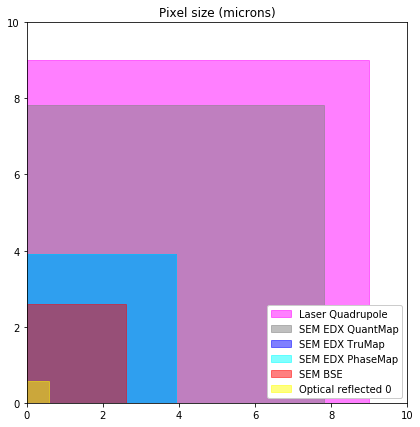

In [8]:
# Sorting by pixel size
dfPyramid_byRes = dfPyramid.sort_values(by=['binnedResolution'], ascending = False)
dfPyramid_byRes = dfPyramid_byRes.reset_index(drop=True) #resets index for loop

#Plot - comparing pixel sizes
fig1 = plt.figure(figsize=(7, 7)) 
ax = fig1.add_subplot(111) 
ax.set_aspect('equal')

rect_temp = []
for i in range(0, dfPyramid.shape[0]):
    width = dfPyramid_byRes['binnedResolution'][i]
    height = dfPyramid_byRes['binnedResolution'][i]
    temp_pixel = Rectangle((0, 0), width, height, 
                     color = dfPyramid_byRes['userColors'][i], alpha = 0.5) 
    ax.add_patch(temp_pixel) 
    rect_temp.append(temp_pixel)
    

layer_names = dfPyramid_byRes['Layer']
plt.xlim([0, max(dfPyramid_byRes['binnedResolution'])+1]) 
plt.ylim([0, max(dfPyramid_byRes['binnedResolution'])+1]) 
plt.legend(rect_temp, layer_names, loc='lower right', framealpha = 1)
plt.title('Pixel size (microns)')

#Saving image
filename = sample + '_pixelComparison' + '.png'
file_path = os.path.join(directory, filename)
plt.savefig(file_path)

In [9]:
# Sorting by tile area (microns^2)
dfPyramid_byArea = dfPyramid.sort_values(by=['tileArea'], ascending = False)
dfPyramid_byArea = dfPyramid_byArea.reset_index(drop=True) #resets index for loop
valid_index = ~np.isnan(dfPyramid_byArea['tileArea']) #excluding NaN rows
dfPyramid_byArea = dfPyramid_byArea[valid_index]

# Finding reference layer (default value)
index_min = int(np.where(binnedResolution == spatialRes_min)[0]) #int() for indexing

fixedLayer_index = index_min #Python index
movingLayer_index = np.setdiff1d(range(0, dfPyramid_byArea.shape[0]), fixedLayer_index)    

#pyramid block (microns) 
blockWidthSize = blockWidth*dfPyramid_byArea['binnedResolution'][fixedLayer_index]
blockHeightSize = blockHeight*dfPyramid_byArea['binnedResolution'][fixedLayer_index]

#Rescaling reference layer properties 
level = 2 #3rd level of photomicrograph pyramid
scale = pyramid_scale[level]

dfPyramid_byArea.loc[fixedLayer_index, 'Spatial resolution'] = dfPyramid_byArea.loc[fixedLayer_index, 'Spatial resolution']*scale
dfPyramid_byArea.loc[fixedLayer_index, 'binnedResolution'] = dfPyramid_byArea.loc[fixedLayer_index, 'binnedResolution']*scale
dfPyramid_byArea.loc[fixedLayer_index, 'Width'] = dfPyramid_byArea.loc[fixedLayer_index, 'Width']/scale
dfPyramid_byArea.loc[fixedLayer_index, 'Height'] = dfPyramid_byArea.loc[fixedLayer_index, 'Height']/scale
dfPyramid_byArea.loc[fixedLayer_index, 'Tile width'] = dfPyramid_byArea.loc[fixedLayer_index, 'Tile width']/scale
dfPyramid_byArea.loc[fixedLayer_index, 'Tile height'] = dfPyramid_byArea.loc[fixedLayer_index, 'Tile height']/scale

dfPyramid_byArea_pairs = dfPyramid_byArea.iloc[movingLayer_index, :].reset_index(drop=True) #resets index for loop

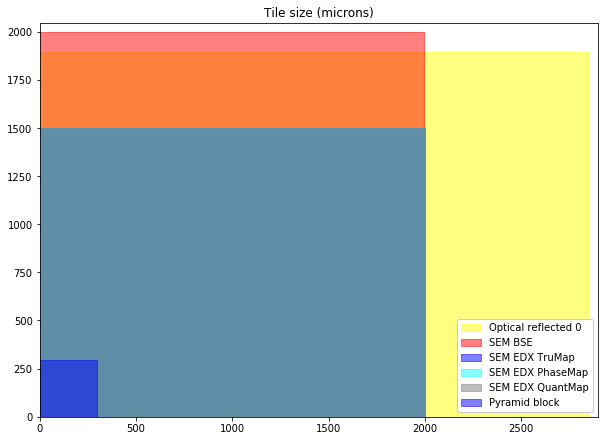

In [10]:

#Plot - comparing tile sizes
fig2 = plt.figure(figsize=(10, 8)) 
ax = fig2.add_subplot(111) 
ax.set_aspect('equal')

rect_temp = []
for i in range(0, dfPyramid_byArea.shape[0]):
    width = dfPyramid_byArea['tileWidthSize'][i]
    height = dfPyramid_byArea['tileHeightSize'][i]
    temp_tile = Rectangle((0, 0), width, height, color = dfPyramid_byArea['userColors'][i], alpha = 0.5) 
    ax.add_patch(temp_tile) 
    rect_temp.append(temp_tile)
    
#adding pyramid block
block_temp = Rectangle((0, 0), blockWidthSize, blockHeightSize, color = 'blue', alpha = 0.5)
rect_temp.append(block_temp)
ax.add_patch(block_temp)
legend_names = dfPyramid_byArea['Layer'].append(pd.Series('Pyramid block'))

plt.xlim([0, max(dfPyramid_byArea['tileWidthSize'])+50]) 
plt.ylim([0, max(dfPyramid_byArea['tileHeightSize'])+50]) 
plt.legend(rect_temp, legend_names, loc='lower right', framealpha = 1)
plt.title('Tile size (microns)')

#Saving image
filename = sample + '_tileComparison' + '.png'
file_path = os.path.join(directory, filename)
plt.savefig(file_path)


In [11]:
#User entry: layer distribution (MatLab registration script)
layer = ['Optical-bf4', 'QuantMap-bf2', 'PhaseMap-bf1', 'BSE-bf1', 'TruMap-bf1']
fixedIndex = 0 #MatLab index, optical (bf=4) 3rd level of LIBVIPS pyramid
del layer[fixedIndex]

n_pairs = len(layer)

print(layer) #MatLab indexes
print(dfPyramid_byArea_pairs['Layer']) #Python indexes

dfPyramid_byArea

['QuantMap-bf2', 'PhaseMap-bf1', 'BSE-bf1', 'TruMap-bf1']
0             SEM BSE
1      SEM EDX TruMap
2    SEM EDX PhaseMap
3    SEM EDX QuantMap
Name: Layer, dtype: object


,Layer,Bit depth,Num. channels,Spatial resolution,Binning factor,Width,Height,Tile width,Tile height,Overlap,Rows,Columns,binnedResolution,userColors,tileWidthSize,tileHeightSize,tileArea,Image size (GB)
0,Optical reflected 0,8,3,2.32,1,18317.75,11074.0,1227.0,816.0,15.0,16.0,17.0,2.32,yellow,2846.64,1893.12,5.389031e+06,12.1
1,SEM BSE,8,1,2.60,1,15943.00,9265.0,768.0,768.0,15.0,14.0,24.0,2.60,red,1996.80,1996.80,3.987210e+06,4.0
2,SEM EDX TruMap,16,28,3.91,1,9267.00,5913.0,512.0,384.0,15.0,18.0,21.0,3.91,blue,2001.92,1501.44,3.005763e+06,225.7
3,SEM EDX PhaseMap,8,1,3.91,1,9267.00,5913.0,512.0,384.0,15.0,18.0,21.0,3.91,cyan,2001.92,1501.44,3.005763e+06,4.0
4,SEM EDX QuantMap,32,28,3.91,2,4633.00,2956.0,256.0,192.0,15.0,18.0,21.0,7.82,grey,2001.92,1501.44,3.005763e+06,451.4


In [12]:
#Importing control points (from MatLab)
controlPoints = []
for i in range(1, n_pairs+1): #Manual input: skip 1st empty sheet
    df = pd.read_excel('controlPoints1.xlsx', sheet_name='sheet_'+str(i), header= None)
    controlPoints.append(df)

#Rearranging MatLab --> Python 
#Manual input; with a GUI or naming convention it should be automatic
controlPoints_sort = [controlPoints[2], controlPoints[3], controlPoints[1], 
                    controlPoints[0]]

#Matching coordinate origins(top left corner: MatLab = bottom left: Python)
#Fixed image
for i in range(0, n_pairs):
    controlPoints_sort[i].iloc[:, 3] = (dfPyramid_byArea['Height'][fixedLayer_index] - 
                                        controlPoints_sort[i].iloc[:, 3])
    
#Moving images
for i in range(0, n_pairs):
    controlPoints_sort[i].iloc[:, 1] = (dfPyramid_byArea_pairs['Height'][i] - 
                                        controlPoints_sort[i].iloc[:, 1])

# print(controlPoints_sort)

In [13]:
#Finding geometric transform (skimage format)
pairs_tform = []
for i in range(0, n_pairs):
    src = np.array(controlPoints_sort[i].iloc[:, 0:2]) #moving
    dst = np.array(controlPoints_sort[i].iloc[:, 2:4]) #fixed
    tform = tf.estimate_transform('similarity', src, dst)
    pairs_tform.append(tform)
    
pairs_tform.insert(fixedLayer_index, []) #useful in loop

# pairs_tform[3].params #for looking specific transformation matrices

Text(0.5, 1.0, 'Tile size (reference image: 3rd pyramidal level)')

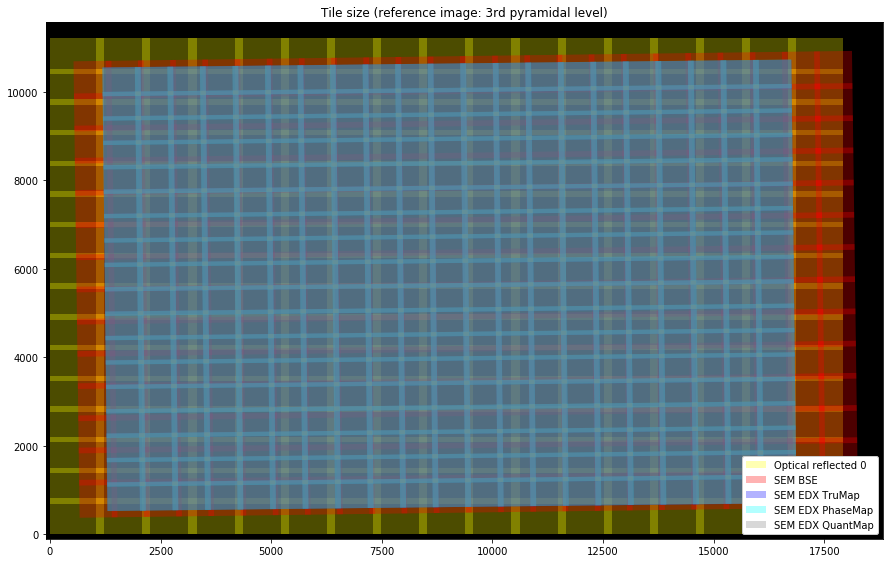

In [14]:
# Whole slide image tiling 

#Plot settings
# mesh_rows = 5
# mesh_cols = 5
overlap = 15 #in general
alpha = 0.3

fig5 = plt.figure(figsize=(15, 16)) 
ax = fig5.add_subplot(111) 
ax.set_aspect('equal')

UpToLayer = dfPyramid_byArea.shape[0]
temp_mesh = [] #for legend color
for k in range(0, UpToLayer):    
   
    width = dfPyramid_byArea['Tile width'][k]
    height = dfPyramid_byArea['Tile height'][k]
    userColor = dfPyramid_byArea['userColors'][k]
    layerColumns = int(dfPyramid_byArea['Columns'][k])
    layerRows = int(dfPyramid_byArea['Rows'][k])
    
    for i in range(0, layerRows): #Y
        for j in range(0, layerColumns): #X
            bottomLeftX = width*j*(100-overlap)/100
            bottomLeftY = height*i*(100-overlap)/100
            
            temp_rect = Rectangle((bottomLeftX, bottomLeftY), width, height, 
                             facecolor= userColor, alpha = alpha) 
            
            if not k == fixedLayer_index:    
                t = mpl.transforms.Affine2D(matrix= pairs_tform[k].params) + ax.transData
                temp_rect.set_transform(t)
            
            ax.add_patch(temp_rect) 
        
    temp_mesh.append(temp_rect)

#layout
ax.set_facecolor('black')
plt.xlim([-100, dfPyramid_byArea.loc[fixedLayer_index, 'Width']+500]) 
plt.ylim([-100, dfPyramid_byArea.loc[fixedLayer_index, 'Height']+500]) 
plt.legend(temp_mesh, dfPyramid_byArea['Layer'], loc='lower right', framealpha = 1)
plt.title('Tile size (reference image: 3rd pyramidal level)')

In [15]:
dfPyramid_byRes2 = dfPyramid_byArea.sort_values(by=['binnedResolution'], ascending = False)
order = dfPyramid_byRes2.index.to_list() #new index
pairs_tform_new = [pairs_tform[i] for i in order]
dfPyramid_byRes2 = dfPyramid_byRes2.reset_index(drop=True) #resets index for loop

index_reference = pairs_tform_new.index([]) #reference image

Text(0.5, 1.0, 'Pixelation in a pyramid block (reference image: 3rd pyramidal level)')

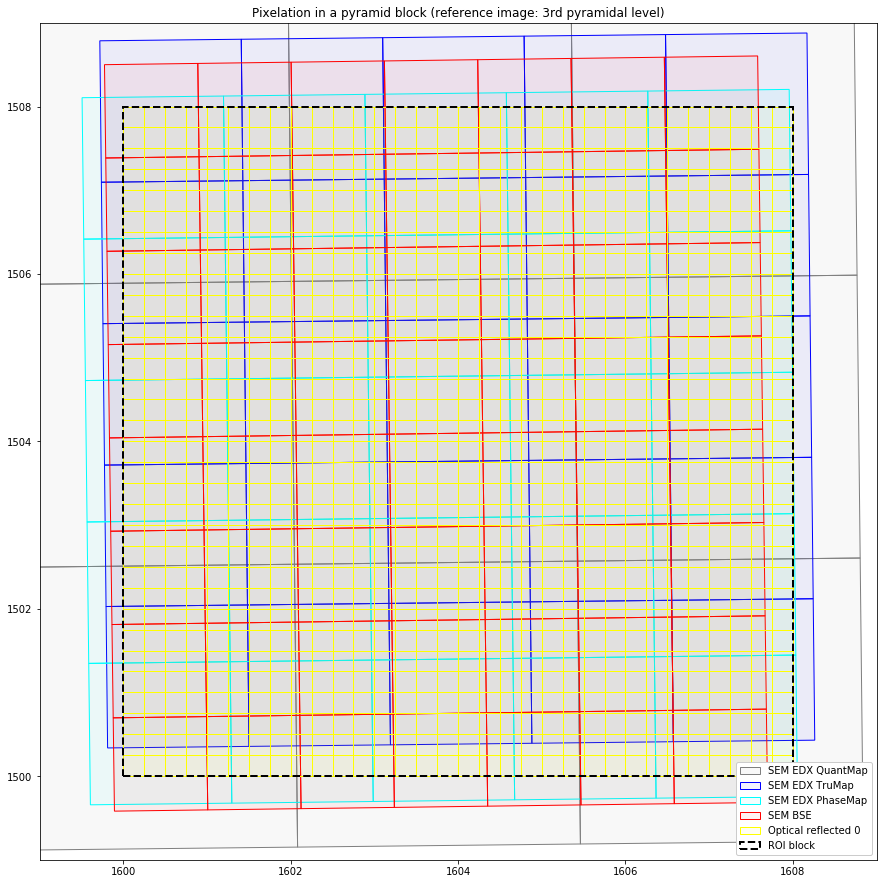

In [17]:
#Plot settings

alpha = 0.05

#ROI 
bottomLeft = (1600, 1500) #tuple
#default size= pyramid block (rescaled to reference image pyramid level) 
block_fraction= 1/16 #computationally expensive plot if =1
block_w = block_fraction*blockWidth/scale
block_h = block_fraction*blockHeight/scale
topRight = (bottomLeft[0] + block_w, bottomLeft[1] + block_h)

temp_block = Rectangle(bottomLeft, block_w, block_h, 
                       edgecolor= 'black', facecolor= 'None', alpha = 1, 
                       linestyle= '--', linewidth= 2) 

#bounding box: reference coordinates
coords = temp_block.get_patch_transform().transform(temp_block.get_path().vertices[:-1])
ones = np.ones(shape=(len(coords), 1)) #ones column
points_ones = np.hstack([coords, ones]) #adding last column for allowing translation
    
# Pixelation in a ROI block

fig6 = plt.figure(figsize=(15, 16)) 
ax = fig6.add_subplot(111) 
ax.set_aspect('equal')

UpToLayer = dfPyramid_byRes2.shape[0]
temp_mesh = [] #for legend color
# br_px_index = [] #optional: for saving index
for k in range(0, UpToLayer):
    
    if not k == index_reference:
        #original coordinates in moving layer 
        x = pairs_tform_new[k].params 
        inverse = np.linalg.inv(x) #Transform matrix^-1

        original_coords = np.dot(inverse, points_ones.T)
        original_coords /= original_coords[2]
        original_coords = original_coords.T #transpose
        original_coords = original_coords[:, :-1] #neglecting ones column

        x_min = min(original_coords[:, 0]) #clamp block
        y_min = min(original_coords[:, 1]) 
        x_max = max(original_coords[:, 0])
        y_max = max(original_coords[:, 1])
        bounding_rect = np.array([[x_min, y_min], [x_max, y_min], 
                                  [x_max, y_max], [x_min, y_max]])
    else:
        #reference coordinates in fixed layer 
        bounding_rect = coords*scale #optional: use scale for plotting original pixel size 
        
    #Pixel indexes for next loop
    bounding_rect_px = np.round(bounding_rect).astype(int) 
    temp_index = np.array([bounding_rect_px[0], bounding_rect_px[2]])
#     br_px_index.append(temp_index) #optional: for saving pixel indexes
    
    #To reference coordinates (pixels)
    if not k == index_reference:
        width = 1
        height = 1
    else: 
        width = 1/scale #optional: use scale for plotting original pixel size 
        height = 1/scale
    
    userColor = dfPyramid_byRes2['userColors'][k]
    
    for i in range(temp_index[0, 1], temp_index[1, 1]): #Y
        for j in range(temp_index[0, 0], temp_index[1, 0]): #X
            bottomLeftX = width*j
            bottomLeftY = height*i
            
            temp_rect = Rectangle((bottomLeftX, bottomLeftY), width, height, 
                             edgecolor= cm.colors.to_rgba(userColor, 1), 
                                  facecolor= cm.colors.to_rgba(userColor, alpha)) 
            
            if not k == index_reference:    
                t = mpl.transforms.Affine2D(matrix= pairs_tform_new[k].params) + ax.transData
                temp_rect.set_transform(t)
            
            ax.add_patch(temp_rect) 
        
    temp_mesh.append(temp_rect)

#adding ROI frame
ax.add_patch(temp_block)
temp_mesh.append(temp_block)
legend_names = dfPyramid_byRes2['Layer'].append(pd.Series('ROI block'))

#Layout
plt.xlim([bottomLeft[0]-1, topRight[0]+1]) 
plt.ylim([bottomLeft[1]-1, topRight[1]+1])
plt.legend(temp_mesh, legend_names, loc='lower right', framealpha = 1)
plt.title('Pixelation in a pyramid block (reference image: 3rd pyramidal level)')